## MVP Theory

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
%matplotlib inline
from pylab import mpl, plt
from scipy.optimize import minimize
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=5, suppress=True,
                   formatter={'float': lambda x: f'{x:6.3f}'})

import datetime

import statsmodels.api as sm
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

In [2]:
#sns.set_style('whitegrid')
#pd.options.display.float_format = '{:,.2f}'.format

In [3]:
path = '../data/'
raw = pd.read_csv(path+'sp500_closefull.csv', index_col='Date', parse_dates=True)

In [5]:
symbols = ['CSCO', 'ISRG', 'TROW', 'BA', 'VRTX', 'M', 'CRM','BLK']
symbols

['CSCO', 'ISRG', 'TROW', 'BA', 'VRTX', 'M', 'CRM', 'BLK']

In [6]:
rets = np.log(raw[symbols] / raw[symbols].shift(1)).dropna()

In [7]:
rets

CSCO      ISRG      TROW        BA      VRTX         M  \
Date                                                                     
2010-01-05 -0.004465 -0.004512  0.011151  0.032227 -0.033559 -0.011793   
2010-01-06 -0.006531  0.014405 -0.015757  0.029883 -0.017687  0.014134   
2010-01-07  0.004494 -0.003759 -0.000739  0.039684 -0.012690  0.022551   
2010-01-08  0.005286 -0.005519 -0.003889 -0.009693 -0.020203 -0.033133   
2010-01-11 -0.002843  0.007513  0.007025 -0.011921  0.028123 -0.017890   
...              ...       ...       ...       ...       ...       ...   
2018-12-21 -0.015177 -0.030602 -0.005974 -0.027528 -0.030210 -0.032103   
2018-12-24 -0.038237 -0.025271 -0.021313 -0.034711 -0.029768 -0.001775   
2018-12-26  0.052943  0.060428  0.053850  0.065046  0.063320  0.067974   
2018-12-27  0.010307  0.014441  0.018347  0.010173  0.003269 -0.002991   
2018-12-28 -0.003268  0.005320  0.000328 -0.002399 -0.005868 -0.000666   

                 CRM       BLK  
Date                            
2010-01-05 -0.004286  0.004308  
2010-01-06 -0.001746 -0.020832  
2010-01-07 -0.004447  0.010934  
2010-01-08  0.001485  0.007014  
2010-01-11 -0.006766  0.016150  
...              ...       ...  
2018-12-21 -0.038466 -0.006776  
2018-12-24 -0.012938 -0.020222  
2018-12-26  0.075461  0.052394  
2018-12-27  0.032780  0.017087  
2018-12-28 -0.003854  0.001108  

[2256 rows x 8 columns]

<AxesSubplot:xlabel='Date'>

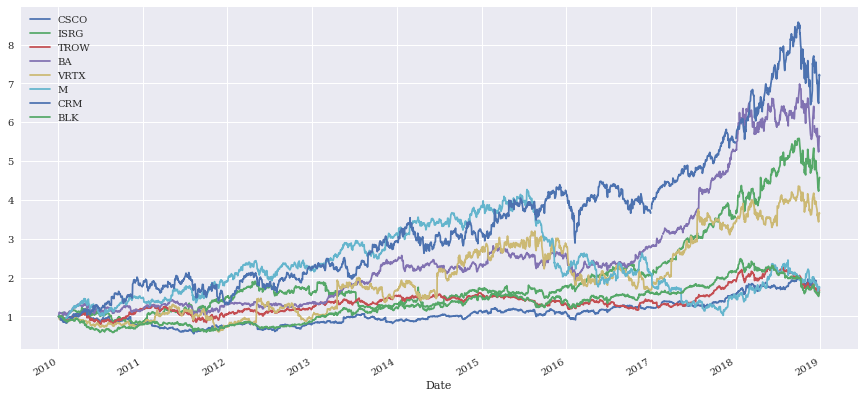

In [8]:
(raw[symbols] / raw[symbols].iloc[0]).plot(figsize=(15,7))

<AxesSubplot:xlabel='Date'>

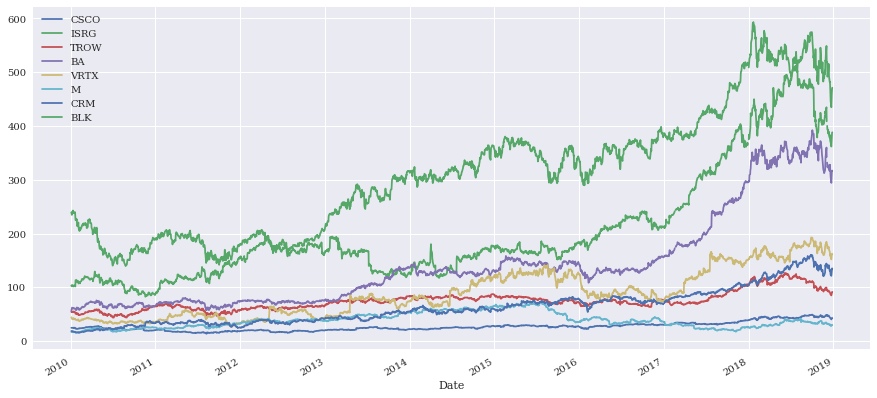

In [9]:
raw[symbols].plot(figsize=(15, 7))

In [10]:
weights = len(rets.columns) * [1 / len(rets.columns)]

In [11]:
def port_return(rets, weights):
    return np.dot(rets.mean(), weights) * 252

In [12]:
port_return(rets, weights)

0.11800047108430317

In [13]:
def port_volatility(rets, weights):
    return np.dot(weights, np.dot(rets.cov() * 252, weights)) ** 0.5

In [14]:
port_volatility(rets, weights)

0.20195879034582062

In [15]:
def port_sharpe(rets, weights):
    return port_return(rets, weights) / port_volatility(rets, weights)

In [16]:
port_sharpe(rets, weights)

0.5842799458357179

In [17]:
w = np.random.random((1000, len(symbols)))

In [18]:
w = (w.T / w.sum(axis=1)).T

In [19]:
w[:5]

array([[ 0.034,  0.032,  0.240,  0.076,  0.151,  0.229,  0.048,  0.191],
       [ 0.142,  0.071,  0.146,  0.201,  0.224,  0.008,  0.032,  0.176],
       [ 0.231,  0.033,  0.009,  0.264,  0.015,  0.060,  0.280,  0.108],
       [ 0.190,  0.089,  0.231,  0.050,  0.015,  0.223,  0.118,  0.085],
       [ 0.089,  0.126,  0.112,  0.065,  0.014,  0.149,  0.220,  0.224]])

In [20]:
pvr = [(port_volatility(rets[symbols], weights), 
       port_return(rets[symbols], weights))
      for weights in w]
pvr = np.array(pvr)

In [21]:
psr = pvr[:, 1] / pvr[:, 0]

Text(0.5, 1.0, 'CSCO | ISRG | TROW | BA | VRTX | M | CRM | BLK')

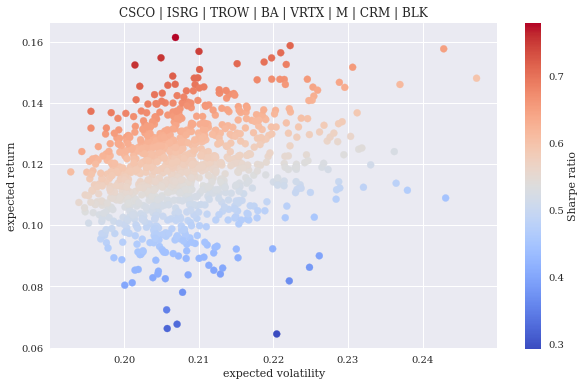

In [22]:
plt.figure(figsize=(10, 6))
fig = plt.scatter(pvr[:, 0], pvr[:, 1],
                 c=psr, cmap='coolwarm')
cb = plt.colorbar(fig)
cb.set_label('Sharpe ratio')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title(' | '.join(symbols))

In [23]:
bnds = len(symbols) * [(0, 1),]
bnds

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

In [24]:
cons = {'type' : 'eq', 'fun' : lambda weights: weights.sum() - 1}

In [25]:
opt_weights = {}
for year in range(2010, 2018):
    rets_ = rets[symbols].loc[f'{year}-01-10':f'{year}-12-28']
    ow = minimize(lambda weights: -port_sharpe(rets_, weights),
                 len(symbols) * [1 / len(symbols)],
                 bounds=bnds,
                 constraints=cons)['x']
    opt_weights[year] = ow

In [26]:
opt_weights

{2010: array([ 0.000,  0.000,  0.000,  0.000,  0.000,  0.385,  0.615,  0.000]),
 2011: array([ 0.000,  0.877,  0.000,  0.000,  0.000,  0.123,  0.000,  0.000]),
 2012: array([ 0.000,  0.000,  0.000,  0.000,  0.035,  0.000,  0.855,  0.111]),
 2013: array([ 0.000,  0.000,  0.000,  0.725,  0.010,  0.253,  0.005,  0.007]),
 2014: array([ 0.691,  0.116,  0.000,  0.000,  0.097,  0.096,  0.000,  0.000]),
 2015: array([ 0.000,  0.000,  0.000,  0.127,  0.000,  0.000,  0.873,  0.000]),
 2016: array([ 0.325,  0.323,  0.000,  0.207,  0.000,  0.000,  0.000,  0.145]),
 2017: array([ 0.052,  0.252,  0.118,  0.397,  0.054,  0.000,  0.038,  0.089])}

In [27]:
res = pd.DataFrame()
for year in range(2010, 2018):
    rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-28']
    epv = port_volatility(rets_, opt_weights[year])
    epr = port_return(rets_, opt_weights[year])
    esr = epr / epv
    rets_ = rets[symbols].loc[f'{year + 1}-01-01':f'{year + 1}-12-28']
    rpv = port_volatility(rets_, opt_weights[year])
    rpr = port_return(rets_, opt_weights[year])
    rsr = rpr / rpv
    res = res.append(pd.DataFrame({'epv' : epv, 'epr' : epr, 'esr' : esr,
                                   'rpv' : rpv, 'rpr' : rpr, 'rsr' : rsr},
                                  index=[year + 1]))

In [28]:
res.mean()

epv    0.235510
epr    0.396846
esr    1.921520
rpv    0.242699
rpr    0.076954
rsr    0.587374
dtype: float64

In [30]:
res[['epv', 'rpv']].corr()

epv       rpv
epv  1.000000  0.710613
rpv  0.710613  1.000000

<AxesSubplot:title={'center':'Expected vs. Realized Portfolio Volatility'}>

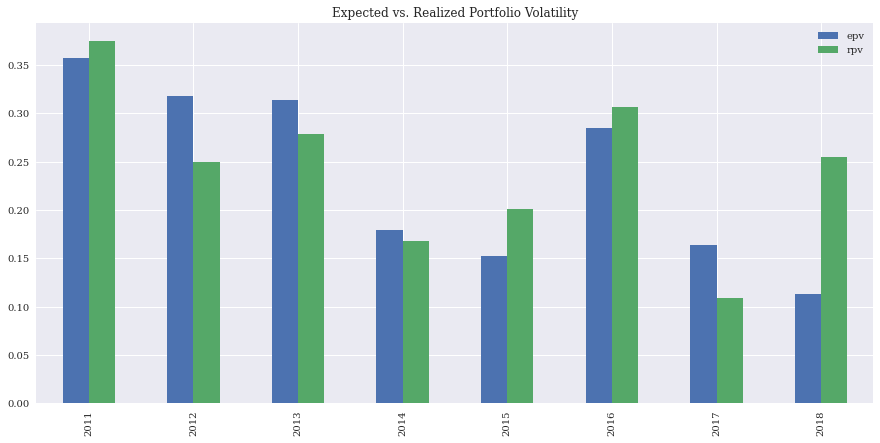

In [33]:
res[['epv', 'rpv']].plot(kind = 'bar', figsize=(15,7),
                        title = 'Expected vs. Realized Portfolio Volatility')

In [32]:
res[['epr', 'rpr']].corr()

epr       rpr
epr  1.000000 -0.341815
rpr -0.341815  1.000000

<AxesSubplot:title={'center':'Expected vs. Realized Portfolio Returns'}>

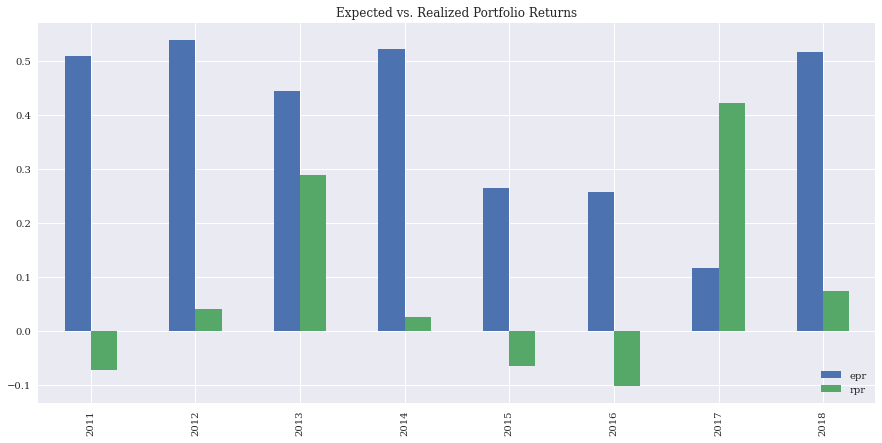

In [34]:
res[['epr', 'rpr']].plot(kind = 'bar', figsize=(15,7),
                        title = 'Expected vs. Realized Portfolio Returns')

In [35]:
res[['esr', 'rsr']].corr()

esr       rsr
esr  1.000000 -0.309833
rsr -0.309833  1.000000

<AxesSubplot:title={'center':'Expected vs. Realized Sharpe Returns'}>

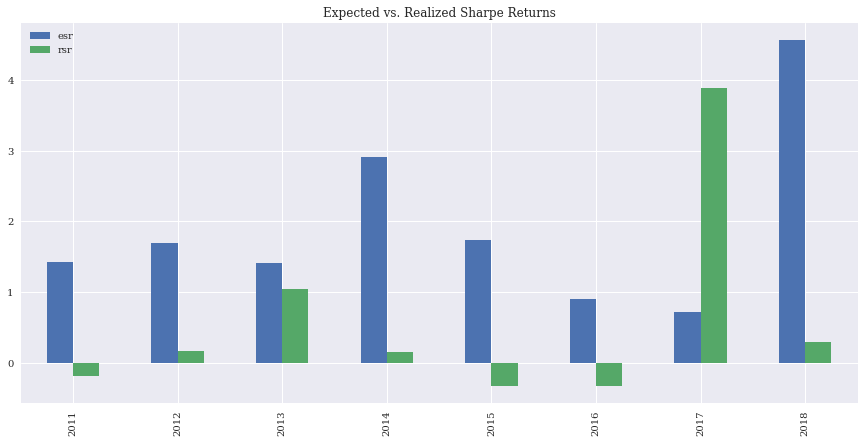

In [37]:
res[['esr', 'rsr']].plot(kind = 'bar', figsize=(15,7),
                        title = 'Expected vs. Realized Sharpe Returns')